In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import quandl as qd
import pandas as pd
import random as rm
import datetime as dt
from scipy.spatial.distance import pdist,cdist,squareform
from sklearn.model_selection import KFold
import cvxpy as cvx

import helper as he
from cd.model import utility as ut

In [9]:
import matplotlib as mpl
from matplotlib import rc
# rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':9})
rc('mathtext',fontset='cm')
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.figsize': (5,3.5)}
import matplotlib.gridspec as gridspec

In [8]:
# Part I
# Get data
qd.ApiConfig.api_key = 'TFPsUSNkbZiK8TgJJ_qa'

vix = qd.get('CBOE/VIX')[['VIX Close']]
vix = vix.rename(columns={'VIX Close':'vix'})

nas = qd.get('NASDAQOMX/COMP')[['Index Value']]
nas = nas.rename(columns={'Index Value':'nas'})

amz = qd.get_table('WIKI/PRICES', ticker = 'AMZN')[['date','close']].set_index('date')
amz = amz.rename(columns={'close':'amz'})


In [10]:
# Part II
# Create dataset
t = nas.join([vix,amz],how='inner')

In [11]:
len(t)

3579

Text(0,0.5,"Valeur normalisée de l'instrument")

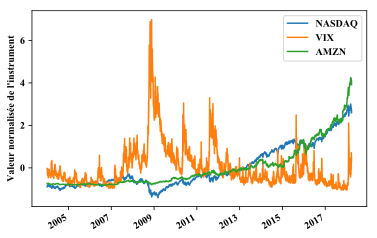

In [12]:
((t-t.mean())/t.std()).plot()
plt.legend(['NASDAQ','VIX','AMZN'])
plt.ylabel('Valeur normalisée de l\'instrument')
#plt.savefig('fig/corr1.pdf',bbox_inches='tight')

In [13]:
R = t['amz'].shift(-1)
R = R/R.shift(1) - 1
R = (R - R.mean())/R.std()

t = t/t.shift(1) - 1
t = (t - t.mean())/t.std()
#t = t/t.std()

t['mnas'] = t.nas.rolling(5).mean()
t['mvix'] = t.vix.rolling(5).mean()
t['mamz'] = t.amz.rolling(5).mean()

t['vnas'] = t.nas.rolling(5).std()
t['vvix'] = t.vix.rolling(5).std()
t['vamz'] = t.amz.rolling(5).std()

t['bias'] = 1

t = t.dropna()
R = R.dropna()
R = R.loc[t.index.intersection(R.index)]
t = t.loc[t.index.intersection(R.index)]

## Utilité

In [14]:
X = t.values
r = R.values

In [42]:
mu = 3
u = ut.LipschitzExpUtility(mu)
#u = ut.LinearUtility(1)
#u = ut.LinearPlateauUtility(0.5,10)

In [43]:
r.mean()

0.00040087876775250303

Text(0.5,1,"b) Distribution de l'utilité")

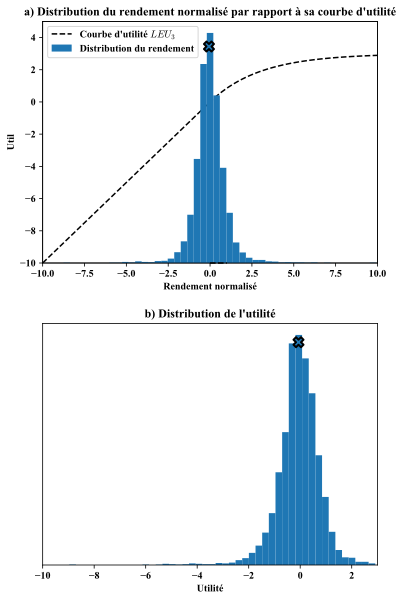

In [44]:
fig,[u_ax,ur_ax] = plt.subplots(2,1,figsize=(6,10))
fig.subplots_adjust(hspace=0.25)
x=np.linspace(-10,10,100)
u_ax.plot(x,u(x),'k--')
u_ax.set_ylim([-10,5])
u_ax.set_xlim([-10,10])
hist_ax = u_ax.twinx()
h = hist_ax.hist(r,bins=50,label='Distribution du rendement');
hist_ax.yaxis.set_ticks([],[])
hist_ax.plot([u(r).mean()],[780],color='C0',marker='X',markersize=10,markeredgewidth=2,markeredgecolor='black')
hist_ax.plot([0,0],'k--',label=f'Courbe d\'utilité $LEU_{mu}$')
hist_ax.set_xlim([-10,10])
#hist_ax.legend([,],loc='upper left')
hist_ax.legend(loc='upper left')
u_ax.set_xlabel('Rendement normalisé')
u_ax.set_ylabel('Util')
u_ax.set_title('a) Distribution du rendement normalisé par rapport à sa courbe d\'utilité')



ur_ax.hist(u(r),bins=50,range=(-10,max(u(r))));
#ur_ax.legend(['Distribution de l\'utilité'])
ur_ax.yaxis.set_ticks([],[])
ur_ax.plot([u(r).mean()],[550],color='C0',marker='X',markersize=10,markeredgewidth=2,markeredgecolor='black')
ur_ax.set_xlim([-10,mu])
ur_ax.set_xlabel('Utilité')
ur_ax.set_title('b) Distribution de l\'utilité')

#plt.savefig('fig/corr2.pdf',bbox_inches='tight')

# Noyau linéaire

In [45]:
shuffle_test = True
shuffle_valid = False

In [46]:
def get_train_test(shuffle):
    l = len(X)
    if shuffle:
        index = rm.sample(range(l),l)
    else:
        index = list(range(l))

    train = index[:int(4*l/5)]
    test = index[int(4*l/5):]
    return train,test

In [47]:
train,test = get_train_test(shuffle=False)

In [48]:
import importlib

In [49]:
importlib.reload(he)

<module 'helper' from '/Users/TBM/Recherche/Memoire/experiments/helper.py'>

In [50]:
# Cross validation pour lambda
folds = 5
kf = KFold(n_splits=5,shuffle=False)
best_lambs = []
results = []
lambs = np.logspace(-5,0,5)
for train_index,valid in kf.split(X[train]):
    best_eu = -np.inf
    result = []
    for lamb in lambs:
        print(lamb)
        X_train = X[train][train_index]
        r_train = r[train][train_index]
        q = he.solve(X_train*r_train[:,None],u=u,lamb=lamb)[0]
        eu_outsample = (r[train][valid]*(X[train][valid]@q)).mean()
        result.append(eu_outsample)
        if eu_outsample > best_eu:
            best_lamb = lamb
            best_eu = eu_outsample
    best_lambs.append(best_lamb)
    results.append(result)

1e-05
0.00017782794100389227
0.0031622776601683794
0.05623413251903491
1.0
1e-05
0.00017782794100389227
0.0031622776601683794
0.05623413251903491
1.0
1e-05
0.00017782794100389227
0.0031622776601683794
0.05623413251903491
1.0
1e-05
0.00017782794100389227
0.0031622776601683794
0.05623413251903491
1.0
1e-05
0.00017782794100389227
0.0031622776601683794
0.05623413251903491
1.0


In [51]:
lamb = 10**np.log10(best_lambs).mean()
lamb

0.001

In [52]:
def algo(X_train,r_train,X_test,r_test,lamb):
    q = he.solve(X_train*r_train[:,None],u=u,lamb=lamb)[0]
    eu_insample = u(r_train*(X_train@q)).mean()
    eu_outsample = u(r_test*(X_test@q)).mean()
    return q,eu_insample,eu_outsample

def get_result(train,test,lamb):
    return algo(X[train],r[train],X[test],r[test],lamb=lamb)

In [53]:
q,eu_in,eu_out = get_result(train,test,lamb=lamb)

In [54]:
eu_in,eu_out

(0.013787718216206599, 0.005461971489553312)

In [32]:
(r_train[:,None]).shape

(2287, 1)

In [33]:
q1 = he.solve(r[train][:,None],u=u,lamb=lamb)[0]

In [34]:
(q1*r).mean()

-7.496699166635967e-05

(0, 500)

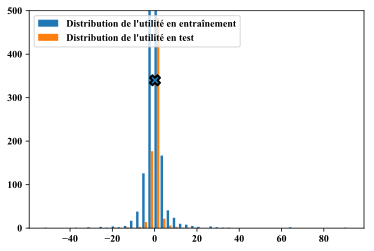

In [36]:
plt.hist([u(r[train]*(X[train]@q)),u(r[test]*(X[test]@q))],bins=50,#range=[-0.5,0.5],
         label=['Distribution de l\'utilité en entraînement','Distribution de l\'utilité en test'])
plt.plot([(r[train]*(X[train]@q)).mean()],[340],color='C0',marker='X',markersize=10,markeredgewidth=2,markeredgecolor='black')
plt.legend(loc='upper left')
plt.ylim([0,500])

In [39]:
lambs = np.logspace(-5,0,25)
results = [result(train,test,lamb) for lamb in lambs]

TypeError: 'list' object is not callable

ValueError: x and y must have same first dimension, but have shapes (25,) and (5, 5)

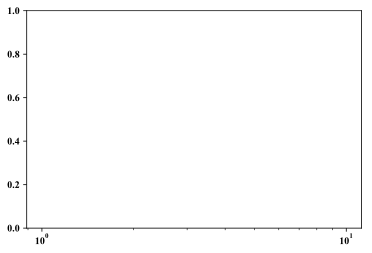

In [38]:
plt.semilogx(lambs,results)
plt.xlabel('$\lambda$')
plt.ylabel('Util')
plt.legend(['Utilité espérée en échantillon','Utilité espérée hors échantillon'],loc='upper left')
plt.ylim([-0.005,0.02])
#plt.savefig('fig/corr3.pdf',bbox_inches='tight')

In [40]:
def get_best_lamb(results):
    best_index = np.argmax(results,axis=0)[1]
    best_lamb = lambs[best_index]
    return best_lamb

In [41]:
lambs = np.logspace(-5,1,15)
best_lambs = []
for i in range(25):
    print(i)
    train,test = get_train_test(shuffle=True)
    results = [get_result(train,test,lamb) for lamb in lambs]
    best = get_best_lamb(results)
    best_lambs.append(best)

0
Failure:Interrupted


KeyError: 'Interrupted'

In [ ]:
def log_mean(v):
    return 10**(np.log10(v).mean())
best_lamb = log_mean(best_lambs)
best_lamb

In [ ]:
best_lamb = 0.007262917501736221

In [ ]:
import importlib
importlib.reload(he)

In [ ]:
results = []
for _ in range(500):
    print(_)
    train,test = get_train_test(shuffle=True)
    try:
        result = get_result(train,test,best_lamb)
        results.append(result)
    except cvx.SolverError:
        continue

In [ ]:
results = np.array(results)
in_sample = results[:,0]
out_sample = results[:,1]
h = plt.hist([in_sample,out_sample],bins=40,normed=True);
plt.legend(['En échantillon','Hors échantillon']);
plt.xlabel('Utilité moyenne')

y_ins = h[0][0]
y_outs = h[0][1]
us = h[1]
i_in = np.argmin(abs(us-in_sample.mean()))
i_out = np.argmin(abs(us-out_sample.mean()))
x_in = us[i_in]
x_out = us[i_out]
y_in = y_ins[i_in]
y_out = y_outs[i_out]
x_in,x_out,y_in,y_out

plt.plot([in_sample.mean()],[y_in],color='C0',marker='X',markersize=10,markeredgewidth=2,markeredgecolor='black')
plt.plot([out_sample.mean()],[y_out],color='C1',marker='X',markersize=10,markeredgewidth=2,markeredgecolor='black')
#plt.savefig('fig/corr4.pdf',bbox_inches='tight')
#plt.hist(in_sample,bins=50,alpha=0.5);
#plt.hist(out_sample,bins=50,alpha=0.5);

In [ ]:
ls=np.logspace(-3,1.5,10)
best_lambs,results = cross_validate(ls,shuffle=False)

In [ ]:
best_lambs

In [ ]:
mean_lamb = 10**(np.log10(best_lambs).mean())

In [ ]:
mean_lamb

In [ ]:

q = he.solve(X[train]*r[train][:,None],u=u,lamb=mean_lamb)[0]

In [ ]:
u(r[test]*(X[test]@q)).mean()

In [ ]:
plt.hist(u(r[test]*(X[test]@q)),bins=50);

In [ ]:
def solve_q(lamb):
    q = he.solve(X_t*r_t[:,None],u=u,lamb=lamb)[0]
    return q

def linear(lamb):
    q = solve_q(lamb)
    ous = u(r_ts*(X_ts@q)).mean()
    ins = u(r_t*(X_t@q)).mean()
    return ins,ous

In [ ]:
ls=np.logspace(-3,1.5,10)
results = [linear(l) for l in ls]

In [ ]:
plt.semilogx(ls,results)
plt.semilogx([min(ls),max(ls)],[0,0],'k--')
plt.legend(['En échantillon','Hors échantillon'])
plt.xlabel('$\lambda$')
plt.ylabel('Utilité standardisée moyenne')
plt.title('Apprentissage par noyau linéaire');

In [ ]:
u(r_ts).mean()

In [ ]:
best = np.argmax(np.array(results)[:,1])

In [ ]:
q_best = solve_q(ls[best])

In [ ]:
q_best

In [ ]:
(r_ts*(X_ts@q_best)).mean()

In [ ]:
results = pd.DataFrame(q_best,columns=['q'])
results.index = ['Biais'] + list(t.drop('r',axis=1).columns)
names = {'nas':'Nasdaq (%)','vix':'VIX (%)','amz':'AMZN (%)',
         'mvix':'VIX m5','mamz':'AMZN m5','mnas':'NASDAQ m5',
         'vvix':'VIX v5','vamz':'AMZN v5','vnas':'NASDAQ v5'}
results.T.rename(columns=names).T

## Noyau quadratique

In [ ]:
def quad1(x):
    return np.array(list(x1*x2 for x1,x2 in it.product(X[0],X[0])))

In [ ]:
phiX = np.apply_along_axis(quad1,1,X_t)

In [ ]:
l = len(phiX)
#sample = rm.sample(range(l),l)
sample = list(range(l))
train,test = sample[:int(4*l/5)],sample[int(4*l/5):]
X_t,X_ts = phiX[train],phiX[test]
r_t,r_ts = r[train],r[test]

In [ ]:
def solveq_q(lamb):
    q = he.solve(phiX*r_t[:,None],u=u,lamb=lamb)[0]
    return q

def quadrat(lamb):
    q = solveq_q(lamb)
    ous = u(r_ts*(X_ts@q)).mean()
    ins = u(r_t*(X_t@q)).mean()
    return ins,ous

In [ ]:
ls=np.logspace(-3,1.5,10)
results = [linear(l) for l in ls]

In [ ]:
plt.semilogx(ls,results)
plt.semilogx([min(ls),max(ls)],[0,0],'k--')
plt.legend(['En échantillon','Hors échantillon'])
plt.xlabel('$\lambda$')
plt.ylabel('Utilité standardisée moyenne')
plt.title('Apprentissage par noyau linéaire');

## Noyau gaussien

In [4]:
sigma = 0.5
def gauss_K(X1,X2=None):
    if X2 is None:
        K = np.exp(-squareform(pdist(X1))**2/sigma)
        return K
    else:
        K = np.exp(-cdist(X1,X2)**2/sigma).T
        return K

In [5]:
K = gauss_K(X_t)

NameError: name 'X_t' is not defined

In [ ]:
a = he.solve_k(K,r_t,u,lamb=0.1)

In [ ]:
(r_t*(K@a)).mean()